In [1]:
import torch.nn as nn
import tensorflow as tf
import functools
import torch
import numpy as np
from scipy import special as sf
from scipy.stats import binom as spbinom
from numba import njit,float64,int64,jit
from numba.types import UniTuple
from matplotlib import pyplot as plt
import numba_scipy
import gc
import os
from utils import save_checkpoint_withEval as save_checkpoint
from utils import restore_checkpoint_withEval as restore_checkpoint
from loadDataPipeline import generateData
from torch.utils.data import DataLoader


In [2]:
softplus = nn.functional.softplus

In [3]:
from torch.utils.cpp_extension import load
from models import ncsnpp
from configs.vp import cifar10_ncsnpp_continuous as configLoader
from models import utils as mutils
from models.ema import ExponentialMovingAverage

No ROCm runtime is found, using ROCM_HOME='/opt/rocm-5.4.3'


### Loading the ML model from Song et al.

In [4]:
config =  configLoader.get_config()
config.training.batch_size=100
config.training.snapshot_freq_for_preemption=10
config.training.snapshot_freq=50000
config.training.log_freq=100
config.data.dataset='CELEBA'
config.data.image_size=64

In [5]:
tEnd = 15.
T = 1000
config.model.num_scales=T

### Loading the dataset

In [6]:
data = np.load('dataBuffers/celebA/celebA_64_64.npy')


test_with = 0
batch_sh  = data.shape[0]-test_with
print(f'Getting {batch_sh} samples')

train_loader = DataLoader(data[:batch_sh,], 
                          batch_size=config.training.batch_size, 
                          pin_memory=True, 
                          num_workers=0,
                          shuffle=True,


                          drop_last=True
                          )

train_iter = iter(train_loader)

Getting 202599 samples


### Solving for observation times (noise schedule) and forward solution or directly loading previously saved ones

In [7]:
try:

    data = np.load('forwardSolution.npz', allow_pickle=True)
    cumSolArray=data['cumSolArray']
    brTable=data['brTable']
    observationTimes=data['observationTimes']    
    
except FileNotFoundError:

    from scipy.optimize import bisect

    def f(x):
        return np.log(x/(1-x))

    xEnd = np.exp(-tEnd)
    fGrid = np.linspace(-f(xEnd), f(xEnd), T)
    xGrid = np.array([bisect(lambda x: f(x)-fGrid[i], xEnd/2, 1-xEnd/2) for i in range(T)])
    observationTimes = -np.log(xGrid)    
    
    ### Analytically derived reverse-time transition rate
    brTable = np.zeros((256,256,T))
    for tIndex in range(T):
        p = np.exp(-observationTimes[tIndex])
        for n in range(256):
            for m in range(n):
                brTable[n,m,tIndex] = n-m 
            brTable[n,n,tIndex] = 0

    ### Analytical forward solution, PDF
    from scipy.stats import binom

    support = np.arange(0,256)
    solArray = np.zeros((T+1, 256, 256))
    solArray[0,:,:] = np.eye(256)

    for tIndex in range(T):
        p = np.exp(-observationTimes[tIndex])
        for IC in range(256):
            solArray[tIndex+1,:,IC] =  binom(IC, p).pmf(support)    
            
    ### Analytical forward solution, CDF
    cumSolArray = np.zeros_like(solArray)

    for i in range(solArray.shape[0]):
        for j in range(solArray.shape[1]):
            cumSolArray[i,:,j] = np.cumsum(solArray[i,:,j] )    
            
    np.savez('forwardSolution.npz', cumSolArray=cumSolArray, brTable=brTable, observationTimes=observationTimes)

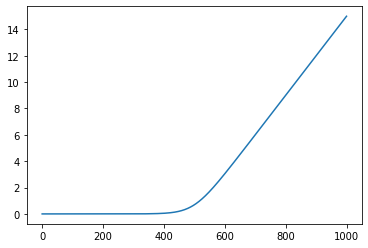

In [8]:
plt.plot(observationTimes)

In [9]:
cumSolArrayGPU = torch.from_numpy(cumSolArray).to(config.device)
brTableGPU = torch.from_numpy(np.ravel(brTable)).to(config.device)
observationTimeGPU = torch.from_numpy(observationTimes).to(config.device)
eobservationTimes = np.hstack([0, observationTimes])

offset = 0.01

ps = np.exp(-eobservationTimes[:-1])
pt = np.exp(-eobservationTimes[1:])

samplingProb = np.ones_like(pt)
samplingProb /= np.sum(samplingProb)

pi = samplingProb

weights = pt*(eobservationTimes[1:]-eobservationTimes[:-1])/pi
weightsGPU = torch.from_numpy(weights).to(config.device)


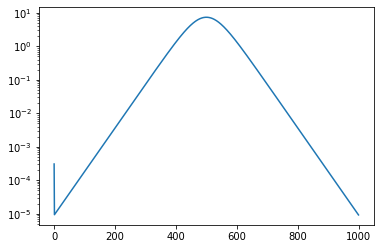

In [10]:
plt.plot( weightsGPU.detach().cpu().numpy() )
plt.gca().set_yscale('log')

### Noisifier

In [11]:
torch.cuda.set_device(config.device)

In [12]:
def generateBatchDataGPU(imgBatch,T):
    
    with torch.no_grad():

        n,nx,ny,nc = imgBatch.shape
        imgBatchGPU = imgBatch.to(config.device).long()
        tIndex = torch.from_numpy(np.random.choice(T, size=(n,1,1,1), p=samplingProb)).to(config.device)
        
        cp = cumSolArrayGPU[(tIndex+1).long(),:,imgBatchGPU.long()]
        u = torch.cuda.FloatTensor(n,nx,ny,nc,1).uniform_().to(config.device)
        
        nt =  torch.argmax((u < cp).long(), axis=4).int()
        index = imgBatchGPU*256*T + nt*T + tIndex.long()
        birthRateBatch = brTableGPU[index.long()]  
    
        p = torch.exp(-observationTimeGPU[tIndex.long()])
        width = 1.0 
        mean_v = (255.0/2*p).reshape((n, 1, 1, 1))
        
        return ((nt-mean_v)/width).permute((0,3,1,2)).to(torch.float32), birthRateBatch.permute((0,3,1,2)).to(torch.float32), tIndex[:,0,0,0]


### Visualize one batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

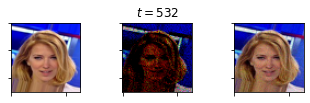

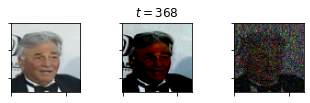

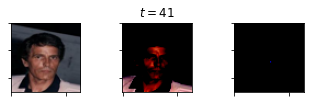

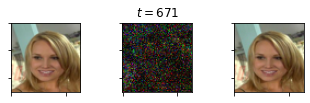

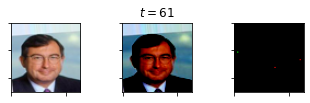

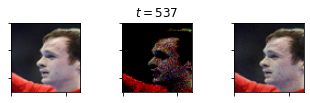

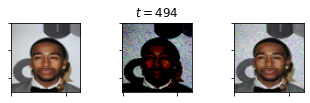

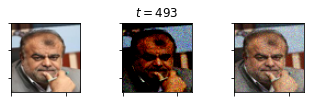

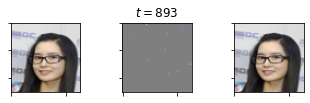

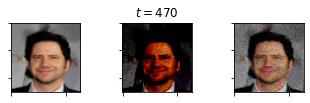

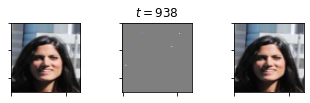

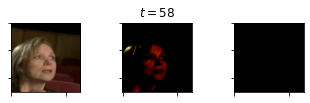

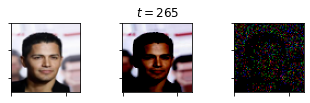

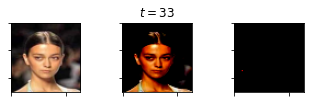

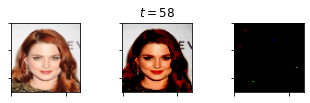

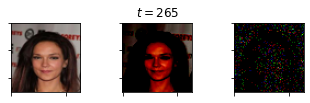

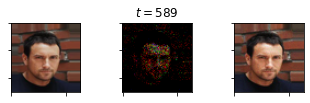

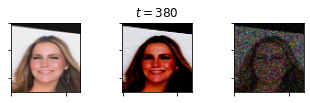

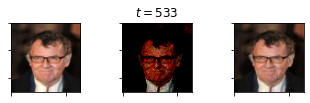

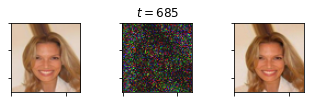

In [13]:
train_batch_GPU = next(train_iter)
train_batch = train_batch_GPU.numpy()

output_image_batch, brRate_batch, tIndexArray = generateBatchDataGPU(train_batch_GPU, T)

output_image_batch = np.transpose(output_image_batch.detach().cpu().numpy(), (0,2,3,1))
brRate_batch = np.transpose(brRate_batch.detach().cpu().numpy(), (0,2,3,1))
tIndexArray = tIndexArray.detach().cpu().numpy()

for i in range(20):
    
    testImage = train_batch[i,:,:,:]
    
    
    output_image = (255.0*(output_image_batch[i,:,:,:]+1.)/2.).astype('int32')
    birthRate = brRate_batch[i,:,:,:]
    targetTime = tIndexArray[i]
    
    fig, ax = plt.subplots(1,3, figsize=(4.8,1.5))
    
    ax[0].imshow(testImage)
    
    if np.amax(output_image)!=0:
        ax[1].imshow(output_image/np.amax(output_image))
    else:
        ax[1].imshow(output_image)
        
    ax[1].set_title('$t='+str(targetTime)+'$')
    
    if np.amax(birthRate)-np.amin(birthRate)!=0:
        ax[2].imshow((birthRate-np.amin(birthRate))/(np.amax(birthRate)-np.amin(birthRate)))
    else:
        ax[2].imshow(birthRate)
        
    for j in range(3):
        
        ax[j].set_xticklabels('')
        ax[j].set_yticklabels('')
    
    fig.tight_layout()


### Instantiate an ML model to learn the transition rate

In [14]:
score_model = mutils.create_model(config)
score_fn = mutils.get_model_fn(score_model, train=True)
optimizer = torch.optim.Adam(score_model.parameters(),lr=config.optim.lr) 

ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)

train_batch = next(train_iter).to(config.device).float()
train_batch = train_batch.permute(0, 3, 1, 2)
imgBatch = train_batch

workdir = 'blackout-celebA64'

state = dict(optimizer=optimizer, model=score_model, ema=ema, lossHistory=[], evalLossHistory=[], step=0)

checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")
tf.io.gfile.makedirs(checkpoint_dir)
tf.io.gfile.makedirs(os.path.dirname(checkpoint_meta_dir))
state = restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])
lossHistory = state['lossHistory']
evalLossHistory = state['evalLossHistory']

### Training

In [15]:
for step in range(initial_step, config.training.n_iters):
    
    try:
        train_batch = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        train_batch = next(train_iter)
        
    output_image_batch, birthRate_batch, tIndexArray = generateBatchDataGPU(train_batch, T)
    
    optimizer.zero_grad()

    y = softplus(score_fn(output_image_batch, tIndexArray))
    
    loss = torch.mean( weightsGPU[tIndexArray.long()].reshape([config.training.batch_size,1,1,1])*(y - birthRate_batch*torch.log(y)))
    
    loss.backward()

    state['ema'].update(state['model'].parameters())
    
    optimizer.step()
    
    lossHistory.append(loss.detach().cpu().numpy())

    if step != 0 and step % config.training.snapshot_freq_for_preemption == 0:
        save_checkpoint(checkpoint_meta_dir, state)
        
    if step != 0 and step % config.training.snapshot_freq == 0 or step == config.training.n_iters:
        save_step = step // config.training.snapshot_freq
        save_checkpoint(os.path.join(checkpoint_dir, f'checkpoint_{save_step}.pth'), state)    
    
    if np.mod(step, config.training.log_freq)==0:
        
        ema.store(score_model.parameters())
        ema.copy_to(score_model.parameters())
        
        y = softplus(score_fn(output_image_batch, tIndexArray))
        
        loss = torch.mean( weightsGPU[tIndexArray.long()].reshape([config.training.batch_size,1,1,1])*(y - birthRate_batch*torch.log(y)))
    
        ema.restore(score_model.parameters())
        
        evalLossHistory.append(loss.detach().cpu().numpy())

        print(f'current iter: {step}, loss: {lossHistory[-1]}, eval loss: {evalLossHistory[-1]}')
        
    state['step'] = step
    state['lossHistory'] = lossHistory
    state['evalLossHistory'] = evalLossHistory
    
    gc.collect()
    torch.cuda.empty_cache()

current iter: 0, loss: 18.565957560311535, eval loss: 18.565957558105318
current iter: 100, loss: -118.19057392640205, eval loss: -113.91113437747016
current iter: 200, loss: -163.02020450174228, eval loss: -159.21992759762603
current iter: 300, loss: -178.87925463586228, eval loss: -175.3624258601684
current iter: 400, loss: -153.25738368343767, eval loss: -150.7635042397634
current iter: 500, loss: -107.11086959103875, eval loss: -105.70157318214952
current iter: 600, loss: -180.06176780748532, eval loss: -177.4970666225811
current iter: 700, loss: -198.54906995510433, eval loss: -196.3372451882979
current iter: 800, loss: -188.24937838920232, eval loss: -186.14346555412843
current iter: 900, loss: -181.7672254197555, eval loss: -180.00371959845836
current iter: 1000, loss: -131.30688781646066, eval loss: -130.2051476911312
current iter: 1100, loss: -114.31864379926489, eval loss: -113.53275742744523
current iter: 1200, loss: -159.4969238706744, eval loss: -158.45988342540355
current

KeyboardInterrupt: 